Tarea 2 Machine learning

Joaquín Olivares y Benjamín Valdés

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample
from sklearn.metrics import make_scorer
from sklearn.feature_selection import mutual_info_regression
import statsmodels.formula.api as sm
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

In [ ]:
#Revisión inicial de la carga
df=pd.read_csv("C:/Users/benja/OneDrive/Escritorio/UAI/2023/Métodos de Aprendizaje de Máquinas/Tarea 2/trainData.csv")
df.head()

,Unnamed: 0,date,fligth_number,origin,destination,distance,noshow,denied_boarding,pax_midlow,pax_high,...,pax_freqflyer,group_bookings,out_of_stock,dom_cnx,int_cnx,p2p,departure_time,capacity,revenues_usd,bookings
0,389083,2009-11-09,8995,BBA,SCL,1394,9.0,0,94,2,...,22,19,0,1,0,239,10:30:00,174.0,10631.1,240
1,177073,2009-05-23,7061,LIM,TRU,489,0.0,0,100,4,...,25,0,0,19,9,192,19:20:00,174.0,5453.7,220
2,1040357,2011-05-09,8972,SCL,PUQ,2180,4.0,0,7,1,...,2,0,0,0,10,69,09:54:00,218.0,16161.0,79
3,505258,2010-02-12,6039,CGH,CNF,524,13.0,0,54,4,...,4,0,0,26,0,64,21:00:00,174.0,10828.7,90
4,369663,2009-10-24,7713,GPS,GYE,1170,14.0,0,21,88,...,0,88,1,23,3,183,12:40:00,144.0,16721.6,209


Se puede ver los vuelos están desordenados en términos temporales en la base de datos y la columna "Unnamed: 0" no aporta información pertinente para este trabajo, ya que solo representa un ID.

Pregunta 1, Pregunta 2 y Pregunta 3

 Limpieza de datos y selección de variables, búsqueda de hiperparámetros y aplicación de kNN para los datos, Búsqueda de hiperparámetros y aplicación de regression tree para los datos.

Se realizarán juntas ya que se irán seleccionando las variables a medida que se van probando distintos k-NN y regression tree.

En este sentido, las características finales de la data, para poder predecir con la data de evalData.csv, dependerá del modelo que tenga mejor rendimiento.

In [ ]:
#Revisión tipos de variables
print(df.dtypes) #Se analizan los dtypes de los datos
#Hay cuatro object y el resto son enteros o decimales.

Unnamed: 0           int64
date                object
fligth_number        int64
origin              object
destination         object
distance             int64
noshow             float64
denied_boarding      int64
pax_midlow           int64
pax_high             int64
pax_midhigh          int64
pax_low              int64
pax_freqflyer        int64
group_bookings       int64
out_of_stock         int64
dom_cnx              int64
int_cnx              int64
p2p                  int64
departure_time      object
capacity           float64
revenues_usd       float64
bookings             int64
dtype: object


In [ ]:
df.dtypes.value_counts()

int64      15
object      4
float64     3
dtype: int64

Se puede ver que todos los tipos son acordes al tipo de variable asociada.

Hay 18 variables numéricas y 4 variables categóricas.

In [ ]:
#Revisión de NA's
print("\nRevisión de NA's:")
print(np.sum(df.isna()))


Revisión de NA's:
Unnamed: 0            0
date                  0
fligth_number         0
origin                0
destination           0
distance              0
noshow                0
denied_boarding       0
pax_midlow            0
pax_high              0
pax_midhigh           0
pax_low               0
pax_freqflyer         0
group_bookings        0
out_of_stock          0
dom_cnx               0
int_cnx               0
p2p                   0
departure_time     1418
capacity              0
revenues_usd          0
bookings              0
dtype: int64


Se puede ver que hay 1.418 casos en los que la hora de salida del vuelo es NA. Debido a la baja cantidad de filas con NA, en comparación a la totalidad de los datos (0,14%), se deciden eliminar las filas asociadas a estos NA.

In [ ]:
#Eliminación de NA's
indices_na = df[df['departure_time'].isna()].index
df = df.drop(indices_na)
df = df.reset_index(drop=True)
#Comprobar que ya no hay NA's
print(np.sum(df['departure_time'].isna()))

0


Se comprueba que ya no hay filas con NA asociados.

In [ ]:
#Revisión de duplicados
print(df.duplicated().any())
print(df['Unnamed: 0'].duplicated().any())

False
False


No hay filas ni índices duplicados.

Entendiendo que el objetivo de este trabajo es estimar el número de noshow en un vuelo determinado, se intentará mantener la mayor cantidad de datos posibles para aplicar los modelos, y la mayor cantidad de variables numéricas posibles, con el objetivo de que el modelo pueda ser más preciso al momento de predecir.

Al incluir gran cantidad de variables numéricas, el modelo tiene la oportunidad de capturar más relaciones y patrones en los datos, lo que puede ser fundamental para lograr predicciones más exactas. Sin embargo, al aumentar el número de variables, también es probable que aumente la complejidad del modelo y los tiempos de ejecución, por lo que se requerirá una optimización de hiperparámetros. A partir de esto, mantener un equilibrio entre la cantidad de datos y la cantidad de variables es esencial para obtener los mejores resultados posibles a la hora de predecir la variable noshow.

Con respecto a las variables, por una parte se evaluarán los comportamientos de las variables numéricas.

Y por otro lado, sabiendo que los modelos pedidos usan variables numéricas para poder ser implementados, se buscará la forma de transformar las variables categóricas a numéricas.

Finalmente, con estos cambios aplicados, se evaluarán opciones de forward selection.

In [ ]:
#Revisión variables numéricas
df.describe()

,Unnamed: 0,fligth_number,distance,noshow,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,out_of_stock,dom_cnx,int_cnx,p2p,capacity,revenues_usd,bookings
count,9.984720e+05,998472.000000,998472.000000,998472.000000,998472.000000,998472.000000,998472.000000,998472.000000,998472.000000,998472.000000,998472.000000,998472.000000,998472.000000,998472.000000,998472.000000,998472.000000,998472.000000,998472.000000
mean,6.443126e+05,6111.700900,1461.144915,6.017665,0.047518,75.512378,3.807592,6.319921,57.210294,16.798194,3.833313,0.096365,25.805089,26.702750,107.140540,178.057943,14840.654495,159.648379
std,3.881555e+05,2048.460199,1684.658558,5.111705,0.544812,44.573728,7.247980,10.267712,38.402214,13.835132,12.305842,0.295092,32.195638,43.942971,65.514668,32.689218,17965.509547,68.619310
min,1.000000e+00,10.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,53.000000,-77206.900000,1.000000
25%,3.124498e+05,5383.000000,551.000000,3.000000,0.000000,46.000000,0.000000,0.000000,29.000000,7.000000,0.000000,0.000000,0.000000,0.000000,59.000000,150.000000,6289.775000,110.000000
50%,6.250255e+05,6037.000000,916.000000,5.000000,0.000000,77.000000,1.000000,3.000000,55.000000,14.000000,0.000000,0.000000,12.000000,5.000000,99.000000,174.000000,9696.000000,151.000000
75%,9.466312e+05,7190.000000,1672.000000,8.000000,0.000000,104.000000,4.000000,8.000000,82.000000,23.000000,0.000000,0.000000,42.000000,31.000000,147.000000,174.000000,15736.300000,200.000000
max,1.350331e+06,9264.000000,11380.000000,271.000000,53.000000,344.000000,195.000000,230.000000,296.000000,236.000000,240.000000,1.000000,246.000000,357.000000,564.000000,451.000000,335775.400000,608.000000


Al analizar las variables numéricas y sus estadísticas descriptivas, se puede visualizar de forma preliminar que hay algunas variables que tienen comportamientos, en términos de distribución, que no son normales. Esto se puede ver, por ejemplo, en la variable capacity. Claramente esta variable tiene valores minimos y máximos anormales con respecto al 25%, 50% y 75% ya que se "escapan" mucho de la distribución "general". Esto no es normal en términos distributivos, sin embargo, si es normal en términos explicativos de la variable, ya que esto se puede deber, por ejemplo, a que la data train tiene en su mayoría vuelos que son cortos y con aviones chicos, pero eso no implica que los vuelos largos y con aviones más grandes sean valores atípicos y erróneos. Esta idea se puede confirmar con el "Boxplot de la Variable capacity".

En este sentido, al analizar el resto de variables numéricas, ocurren comportamientos similares en todas las variables. A partir de esto, se decide que no se eliminarán los datos "atípicos" en términos de distribución, ya que en la práctica representan valores reales, por lo que es sumamente importante tenerlos en consideración.

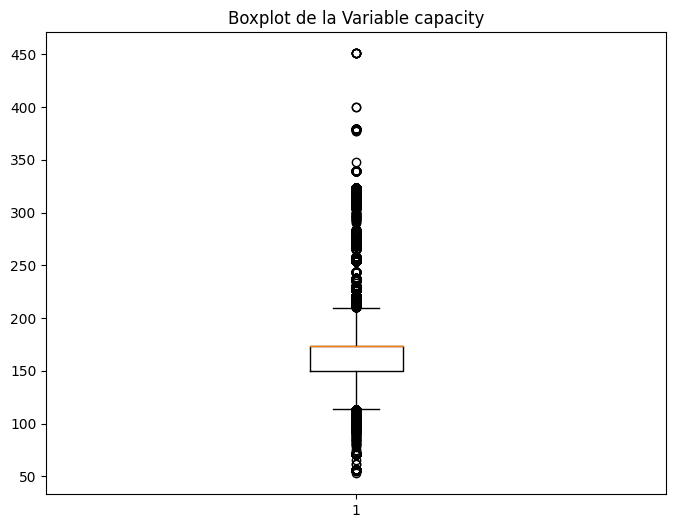

In [ ]:
#Boxplot explicativo de la variable capacity
plt.figure(figsize=(8, 6))  # Esto crea una figura con un tamaño específico
plt.boxplot(df["capacity"])
plt.title("Boxplot de la Variable capacity")
plt.show()

Se puede ver en el boxplot de Capacity que claramente hay muchos outliers (valores muy chicos y valores muy grandes con respecto a la mayoría de los valores en el conjunto de datos), sin embargo, en la realidad son valores que existen y son importantes a tener en consideración.

Con el objetivo de evaluar distintos k-NN y árboles, y quedarse con el mejor, se realizarán varios. Los modelos se diferenciarán en términos de las variables que usarán.

Un punto importante a destacar es que en una primera instancia se evaluaron grillas de hiperparámetros (con la función GridSearchCV) más "grandes" para todos los modelos por igual, pero se fueron reduciendo a medida que se iban corriendo los códigos y se llegaban a resultados. A raíz de esto, hay algunos modelos que tienen muy pocos hiperparámetros, como el segundo k-NN. Esto es consecuencia de un largo proceso iterativo de pruebas, y por otro lado, los altos tiempos de ejecución de los códigos, por lo que se decide solo dejar los hiperparámetros con mejor rendimiento.

Los modelos a realizar son los siguientes:

Primero se realizará uno de cada uno con las variables originales, menos las categóricas: 1 k-NN y 1 árbol.

En segundo lugar uno de cada uno con las variables categóricas pasadas a numéricas y el one hot encoding de las variables origin y destination: 1 k-NN y 1 árbol.

En tercer lugar dos de cada uno con las variables que se obtienen después de aplicar dos métodos de forward selection distintos: 2 k-NN y 2 árboles.

En cuarto lugar, uno de cada uno con las variables originales y solo 2 categóricas pasadas a numéricas (date y departure_time): 1 k-NN y 1 árbol.

Los modelos del 1 al 4 son de k-NN y los modelos del 5 al 8 son de árbol de decisión.

Con el objetivo de que haya robustez a la hora de crear los datos de train y test para cada modelo, y no hayan posibles errores, se crearán los datos de train y test para cada modelo. Esto se realizará aún cuando, por ejemplo, el modelo k-NN y el árbol asociado a usar todas las variables originales menos las categóricas, usen los mismos sets de train y test.

Antes de pasar a la implementación de los modelos, es importante notar que en este trabajo se está buscando predecir la cantidad de noshow, y no clasificar las observaciones de la data de testeo (1 para noshow positivo (no llegan pasajeros, al menos 1) y 0 para noshow negativo (llegan todos los pasajeros)). Por lo que no es un problema de clasificación.

A raíz de esto, no tiene sentido utilizar métricas de evaluación como F1-score, recall, etc.

Como la métrica para evaluar el set de testeo evalData.csv es SMAPE, solo se usará esa misma métrica para definir la mejor opción.

La métrica SMAPE mide el error porcentual de manera simétrica, teniendo en cuenta tanto el valor real como el valor que se predice. SMAPE se expresa en términos de porcentaje, y un valor más bajo indica una mejor precisión del modelo. Esta métrica se usará para comparar las predicciones del modelo con los valores reales; por lo que es una medida de desempeño que permite evaluar la efectividad del modelo en términos de error porcentual. Cuanto menor sea el valor de SMAPE, mejor será la capacidad del modelo para lograr predicciones precisas.

Es importante recalcar que se podrían usar otras métricas como R2, MSE y MAE, pero se decide solo usar SMAPE.

Finalmente, es importante mencionar que para los modelos se usará un sampleo aleatorio de la mitad de los datos (500.000). Este sampleo será el mismo para todos los modelos, para no sesgar los resultados en este sentido. Se hace un sampleo debido al tiempo que se demoran en correr los modelos, sobre todo los k-NN.

Se creará una función SMAPE que será la métrica de evaluación:

In [ ]:
#Crear función SMAPE para que sea la métrica de evaluación
def smape(y_true, y_pred):
    num = np.abs(y_true - y_pred)
    den = np.abs(y_true) + np.abs(y_pred)
    return 100 * np.nan_to_num((num / den).mean())
smape_metric = make_scorer(smape, greater_is_better=False) #para poder usarla en sklearn

In [ ]:
#Función para evaluar modelos
def model_eval(modelo, X_test, y_test, n):
    modelo_test = modelo.predict(X_test)
    print("Modelo:",n)
    print(f"SMAPE: {smape(y_test, modelo_test)}")
    return smape(y_test, modelo_test)

-----------------

Primera opción: variables originales menos las categóricas.

In [ ]:
#PRIMER k-NN: variables originales menos las categóricas y unnamed:0
#Definir variables
df2=df.copy()
df2.drop(['Unnamed: 0','origin', 'destination','date', 'departure_time'], axis=1, inplace=True)

#Generar grupos de train y test
#Se hace sampleo por tiempos de ejecución de los códigos
df3=resample(df2,n_samples=500000,replace=False,random_state=1)
X = df3.drop(columns=['noshow'])
y = df3['noshow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

#k-fold cross validation y obtención del mejor modelo
params1={'n_neighbors':[60,70,80], #Opciones de veciones para k-NN
        'weights': ['uniform','distance'], #Opciones para el peso
        'metric':['euclidean','manhattan'] #Opciones para la métrica de distancia
       }
knn1=KNeighborsRegressor() #Se crea el objeto knn sin especificar hiperparámetros
model1 = GridSearchCV(knn1, params1, n_jobs=-1, cv=5, verbose=3, scoring=smape_metric)
#knn es el modelo base, params los hiperparámetros, n_jobs=-1 para que se usen los núcleos disponibles,
#cv=5 es la cantidad de pliegues para k-fold, verbose=3 para mostrar el ajuste por cada intento y scoring para usar SMAPE
model1.fit(X_train,y_train) #Búsqueda de hiperparámetros con el conjunto de entrenamiento
#results=pd.DataFrame(model1.cv_results_).sort_values(by="rank_test_score") #Resultados
print(model1.best_params_) #Mejores hiperparámetros con SMAPE
model1.best_estimator_ #modelo entrenado con los mejores hiperparámetros

Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'metric': 'manhattan', 'n_neighbors': 80, 'weights': 'distance'}


KNeighborsRegressor(metric='manhattan', n_neighbors=80, weights='distance')

In [ ]:
#Evaluación del modelo
modelo1=model1.best_estimator_
modelo1_eval=model_eval(modelo1, X_test, y_test,n=1)

Modelo: 1
SMAPE: 31.158898656775634


In [ ]:
#PRIMER árbol: variables originales menos las categóricas y unnamed:0
#Definir variables
df2=df.copy()
df2.drop(['Unnamed: 0','origin', 'destination','date', 'departure_time'], axis=1, inplace=True)

#Generar grupos de train y test
#Se hace sampleo por tiempos de ejecución de los códigos
df3=resample(df2,n_samples=500000,replace=False,random_state=1)
X = df3.drop(columns=['noshow'])
y = df3['noshow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

#k-fold cross validation y obtención del mejor modelo
hiper1 = {
    'max_depth': [None, 10, 12, 13], # máxima profundidad del arbol
    'min_samples_split': [5, 10, 12], # numero minimo de puntos para separar un nodo.
    'min_samples_leaf': [4, 5, 6], # numero minimo de puntos que debe tener una hoja.
    #'min_impurity_decrease': [0.0, 0.01, 0.1], # disminución mínima en la impureza para dividir un nodo
    #'max_leaf_nodes': [None, 5, 8, 10] # número máximo de nodos hojas en el árbol
    #'splitter' : ["best"]
}
m = DecisionTreeRegressor()
grid_search1 = GridSearchCV(m, hiper1, cv=5, scoring=smape_metric) #se busca minimizar
grid_search1.fit(X_train, y_train) #Búsqueda de hiperparámetros con el conjunto de entrenamiento
#resultsa1=pd.DataFrame(grid_search1.cv_results_).sort_values(by="rank_test_score") #Resultados
print(grid_search1.best_params_) #Mejores hiperparámetros con SMAPE
grid_search1.best_estimator_

{'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 12}


DecisionTreeRegressor(max_depth=10, min_samples_leaf=4, min_samples_split=12)

In [ ]:
#Evaluación del modelo
mejora1 = grid_search1.best_estimator_ #modelo entrenado con los mejores hiperparámetros
modeloa1_eval=model_eval(mejora1, X_test, y_test,n=5)

Modelo: 5
SMAPE: 31.419696585275027


En el caso de la primera selección de variables, se observa que el modelo k-NN muestra un mejor rendimiento que el modelo de árbol, ya que logra un SMAPE más bajo. Es importante destacar que la diferencia de estos valores es muy baja.

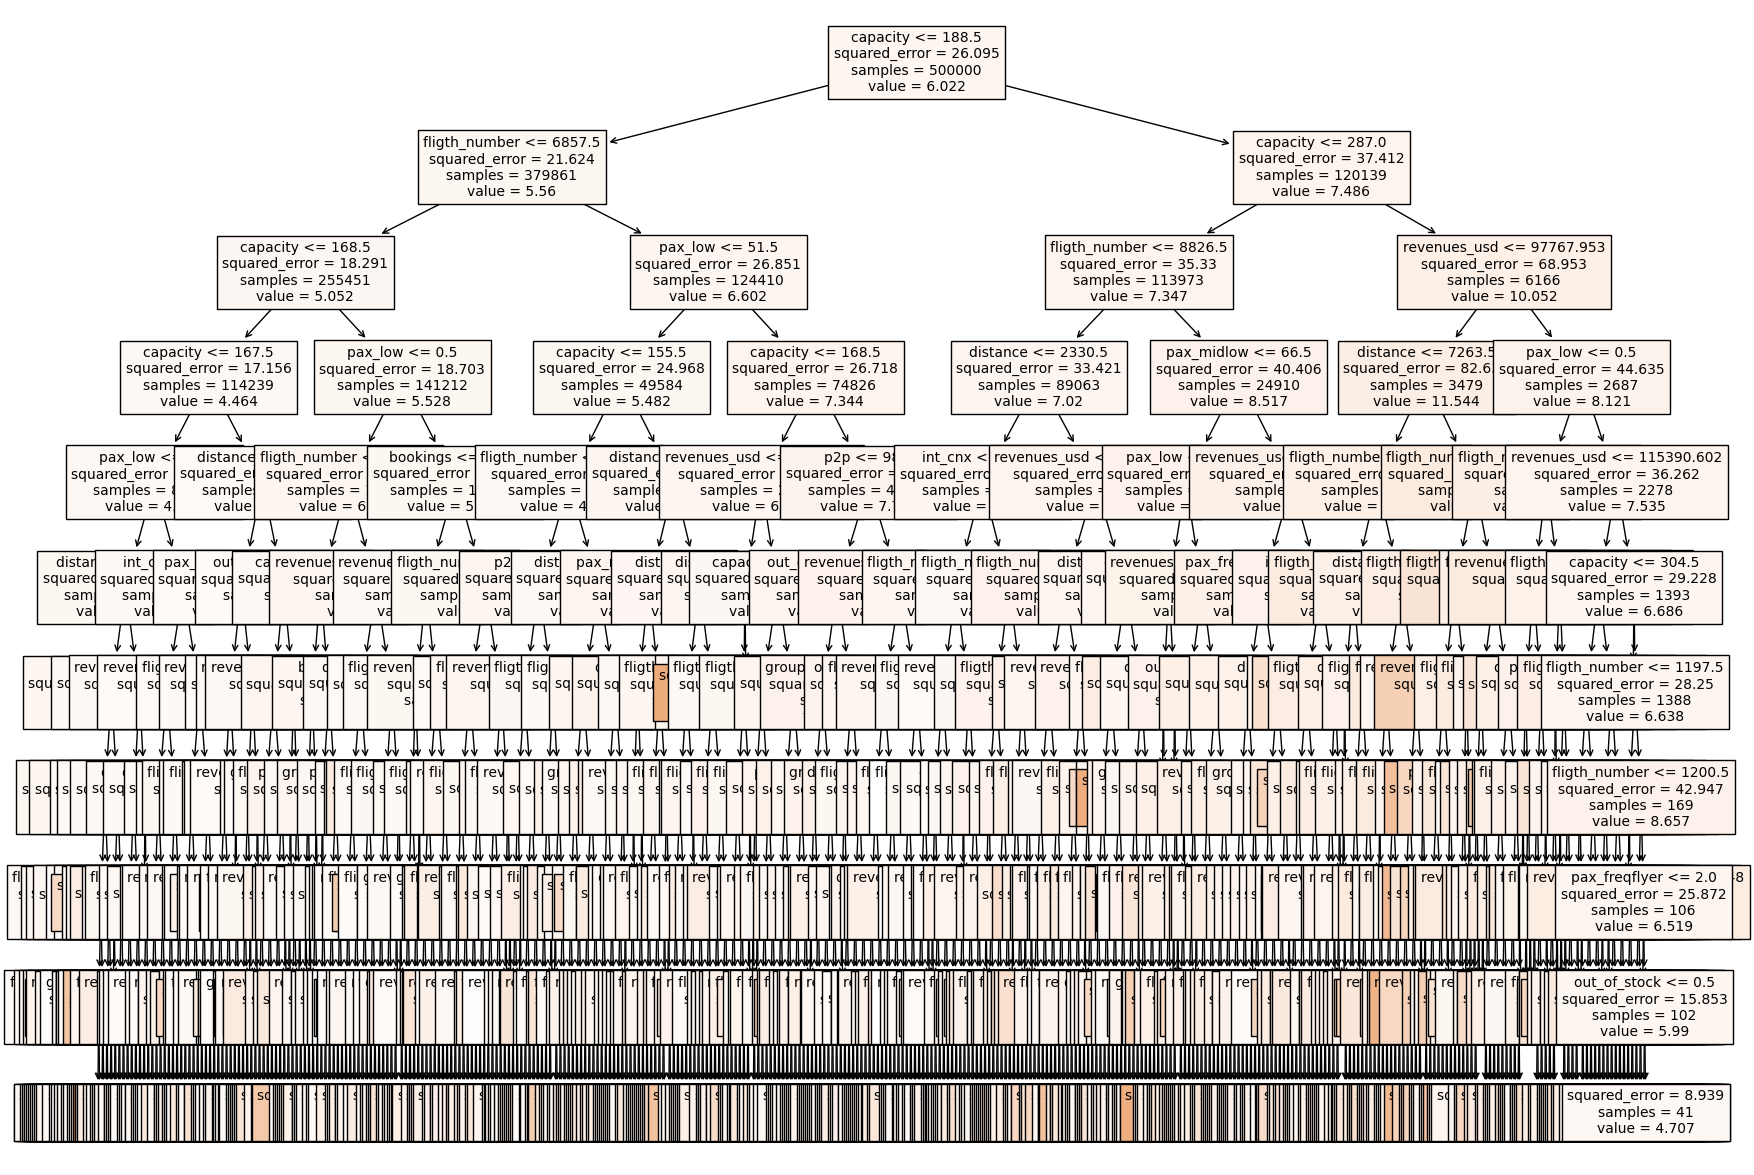

In [ ]:
#Graficando el arbol
mejora1.fit(X, y)
plt.figure(figsize=(20, 15))
plot_tree(mejora1, filled=True, feature_names=X.columns, fontsize=10)
plt.show()

Se muestra el gráfico del modelo de árbol para evidenciar a priori una visión general de su funcionamiento. El modelo utiliza los datos para dividir el conjunto de muestras en subconjuntos más pequeños, decidiendo de manera automática las divisiones. En el gráfico se puede ver una estructura jerárquica de decisiones que permite realizar predicciones a partir de estas divisiones. 

Se presenta el gráfico, pero solo pueden verse claramente las decisiones de división hasta la fila 4, debido a la selección de hiperparámetros. Esto no permite hacer una evaluación simple del árbol de manera visual, pero esta tarea no está enfocada en eso, si no que está enfocada en la evaluación del SMAPE. Debido a esto, se muestra el gráfico solo para complementar.

---------------------------------

Segunda opción: variables categóricas pasadas a numéricas y one hot encoding de las variables origin y destination.

In [ ]:
#Revisión variables categóricas
#Se hará por variable
print(df[['date', 'departure_time', 'origin', 'destination']].head())

         date departure_time origin destination
0  2009-11-09       10:30:00    BBA         SCL
1  2009-05-23       19:20:00    LIM         TRU
2  2011-05-09       09:54:00    SCL         PUQ
3  2010-02-12       21:00:00    CGH         CNF
4  2009-10-24       12:40:00    GPS         GYE


In [ ]:
#Variable date
#Por un tema de simplicidad, se decide que se tomarán en cuenta solo los meses del año para esta variable, con el objetivo de poder pasarla a una variable numérica
df['date'] = pd.to_datetime(df['date'])
df['date2'] = df['date'].dt.month
print(df[['date','date2']].head(3))

        date  date2
0 2009-11-09     11
1 2009-05-23      5
2 2011-05-09      5


In [ ]:
#Variable departure_time
#Por un tema de simplicidad, se decide que se tomará en cuenta solo la hora salida
df['departure_time'] = pd.to_datetime(df['departure_time']).dt.time
df['departure_time2'] = df['departure_time'].apply(lambda x: x.hour)
print(df[['departure_time', 'departure_time2']].head(3))

  departure_time  departure_time2
0       10:30:00               10
1       19:20:00               19
2       09:54:00                9


Se pasó la variable "date" a "date2" teniendo en cuenta solo el mes de la fecha.

Se pasó la variable "departure_time" a "departure_time2" teniendo en cuenta solo la hora.

In [ ]:
#Para evaluar las variables origin y destination, es necesario tener en cuenta la variable flight_number, ya que esta representa la ruta del vuelo
#Como representa la ruta del vuelo, se espera que cada número de vuelo solo tenga un origen y un destino asociado, lo que se comprobará a continuación:
conteo_vuelos = df.groupby(['fligth_number', 'origin', 'destination']).size().reset_index(name='conteo')
conteo_vuelos_erroneos = conteo_vuelos[conteo_vuelos['conteo'] > 1]
if conteo_vuelos_erroneos.empty:
    print("Todos los vuelos tienen el origen y destino correctos.")
else:
    print("Hay vuelos con el mismo número, pero diferentes combinaciones de origen y destino:")
    print(conteo_vuelos_erroneos)

Hay vuelos con el mismo número, pero diferentes combinaciones de origen y destino:
      fligth_number origin destination  conteo
2                12    CNF         GRU      48
3                12    GRU         FOR       2
5                13    GRU         CNF      50
9                15    GRU         FOR       4
10               15    JPA         BSB       9
...             ...    ...         ...     ...
9894           9260    ANF         CCP     130
9895           9261    CCP         ANF     141
9896           9263    PNT         PUQ      81
9897           9263    PUQ         SCL      81
9898           9264    SCL         PNT      83

[7352 rows x 4 columns]


Se puede ver que hay números de vuelos que tienen asociados distintos orígenes y destinos, lo que es un problema y no permite que se puedan eliminar las variables de origen y destino y quedarse solo con el número de vuelo. Para resolver esto, se evaluará la posibilidad de realizar un one hot encoding a las variables origin y destination.

In [ ]:
#Variable origin
distinct_values = df['origin'].nunique()
print(f"La cantidad de valores distintos en la variable 'origin' es: {distinct_values}")

La cantidad de valores distintos en la variable 'origin' es: 155


In [ ]:
#Variable destination
distinct_values = df['destination'].nunique()
print(f"La cantidad de valores distintos en la variable 'destination' es: {distinct_values}")

La cantidad de valores distintos en la variable 'destination' es: 157


In [ ]:
#Se decide realizar un one hot encoding a estas variables
df2 = df.copy()
df2['origin'] = df2['origin'].astype(str)
df2['destination'] = df2['destination'].astype(str)
all_categories = set(df2['origin']).union(set(df2['destination']))
encoded_cols = pd.get_dummies(df2[['origin', 'destination']], columns=['origin', 'destination'], prefix=['origin', 'destination'])
encoded_cols = encoded_cols.reindex(columns=all_categories, fill_value=0)
df2 = pd.concat([df2, encoded_cols], axis=1)

In [ ]:
#Ahora se eliminan las variables que no se utilizarán
#También se elimina la columna Unnamed:0 ya que es un ID que no sirve para lo que se quiere realizar
df2.drop(['Unnamed: 0','origin', 'destination','date', 'departure_time'], axis=1, inplace=True)
df2.head(4)

,fligth_number,distance,noshow,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,...,UDI,LHR,TUC,AEP,BPS,CJA,YYZ,CRD,PMW,MEX
0,8995,1394,9.0,0,94,2,28,94,22,19,...,0,0,0,0,0,0,0,0,0,0
1,7061,489,0.0,0,100,4,4,87,25,0,...,0,0,0,0,0,0,0,0,0,0
2,8972,2180,4.0,0,7,1,5,64,2,0,...,0,0,0,0,0,0,0,0,0,0
3,6039,524,13.0,0,54,4,7,21,4,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#Segundo k-NN: variables categóricas pasadas a numéricas y one hot encoding de las variables origin y destination.
#Definir variables
#Se hizo antes de esto

#Generar grupos de train y test
#Se hace sampleo por tiempos de ejecución de los códigos
df3=resample(df2,n_samples=500000,replace=False,random_state=1)
X = df3.drop(columns=['noshow'])
y = df3['noshow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

#k-fold cross validation y obtención del mejor modelo
params2={'n_neighbors':[60,70], #Opciones de veciones para k-NN
        'weights': ['uniform','distance'], #Opciones para el peso
        'metric':['euclidean','manhattan'] #Opciones para la métrica de distancia
       }
knn2=KNeighborsRegressor() #Se crea el objeto knn sin especificar hiperparámetros
model2 = GridSearchCV(knn2, params2, n_jobs=-1, cv=5, verbose=3, scoring=smape_metric)
#knn es el modelo base, params los hiperparámetros, n_jobs=-1 para que se usen los núcleos disponibles,
#cv=5 es la cantidad de pliegues para k-fold, verbose=3 para mostrar el ajuste por cada intento y scoring para usar SMAPE
model2.fit(X_train,y_train) #Búsqueda de hiperparámetros con el conjunto de entrenamiento
#results2=pd.DataFrame(model2.cv_results_).sort_values(by="rank_test_score") #Resultados
print(model2.best_params_) #Mejores hiperparámetros con SMAPE
model2.best_estimator_ #modelo entrenado con los mejores hiperparámetros

Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'metric': 'manhattan', 'n_neighbors': 60, 'weights': 'distance'}


KNeighborsRegressor(metric='manhattan', n_neighbors=60, weights='distance')

In [ ]:
#Evaluación del modelo
modelo2=model2.best_estimator_
modelo2_eval=model_eval(modelo2, X_test, y_test,n=2)

Modelo: 2
SMAPE: 30.825633044811944


In [ ]:
#Segundo DecisionTreeRegressor: variables categóricas pasadas a numéricas y one hot encoding de las variables origin y destination.
#Definir variables
#Se hizo antes de esto

#Generar grupos de train y test
#Se hace sampleo por tiempos de ejecución de los códigos
df3=resample(df2,n_samples=500000,replace=False,random_state=1)
X = df3.drop(columns=['noshow'])
y = df3['noshow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

#k-fold cross validation y obtención del mejor modelo
hiper2 = {
    'max_depth': [None, 10, 12, 13], # máxima profundidad del arbol
    'min_samples_split': [5, 10, 12], # numero minimo de puntos para separar un nodo.
    'min_samples_leaf': [4, 5, 6], # numero minimo de puntos que debe tener una hoja.
    #'min_impurity_decrease': [0.0, 0.01, 0.1], # disminución mínima en la impureza para dividir un nodo
    #'max_leaf_nodes': [None, 5, 8, 10] # número máximo de nodos hojas en el árbol
    #'splitter' : ["best"]
}
m2 = DecisionTreeRegressor()
grid_search2a = GridSearchCV(m2, hiper2, cv=5, scoring=smape_metric) #se busca minimizar
grid_search2a.fit(X_train, y_train) #Búsqueda de hiperparámetros con el conjunto de entrenamiento
#resultsa2=pd.DataFrame(grid_search2a.cv_results_).sort_values(by="rank_test_score") #Resultados
print(grid_search2a.best_params_) #Mejores hiperparámetros con SMAPE
grid_search2a.best_estimator_

{'max_depth': 12, 'min_samples_leaf': 4, 'min_samples_split': 12}


DecisionTreeRegressor(max_depth=12, min_samples_leaf=4, min_samples_split=12)

In [ ]:
#Evaluación del modelo
mejora2 = grid_search2a.best_estimator_ #modelo entrenado con los mejores hiperparámetros
modeloa2_eval=model_eval(mejora2, X_test, y_test,n=6)

Modelo: 6
SMAPE: 31.260830119459875


En esta opción, que incluye la transformación de variables categóricas a numéricas y la aplicación de one-hot encoding a las variables 'origin' y 'destination', se puede ver que nuevamente el modelo k-NN tiene un mejor rendimiento en términos de SMAPE que el árbol. En esta opción, la diferencia de SMAPE es bastante más considerable que la diferencia que hay en la opción 1. 

Teniendo en cuenta que tanto k-NN como el árbol tienen mejores rendimientos con respecto a sus respectivos símiles de la opción 1, esto podría sugerir que pasar las variables "date" y "departure_time" a numéricas y/o el one hot encoding son cambios beneficiosos para la predicción.

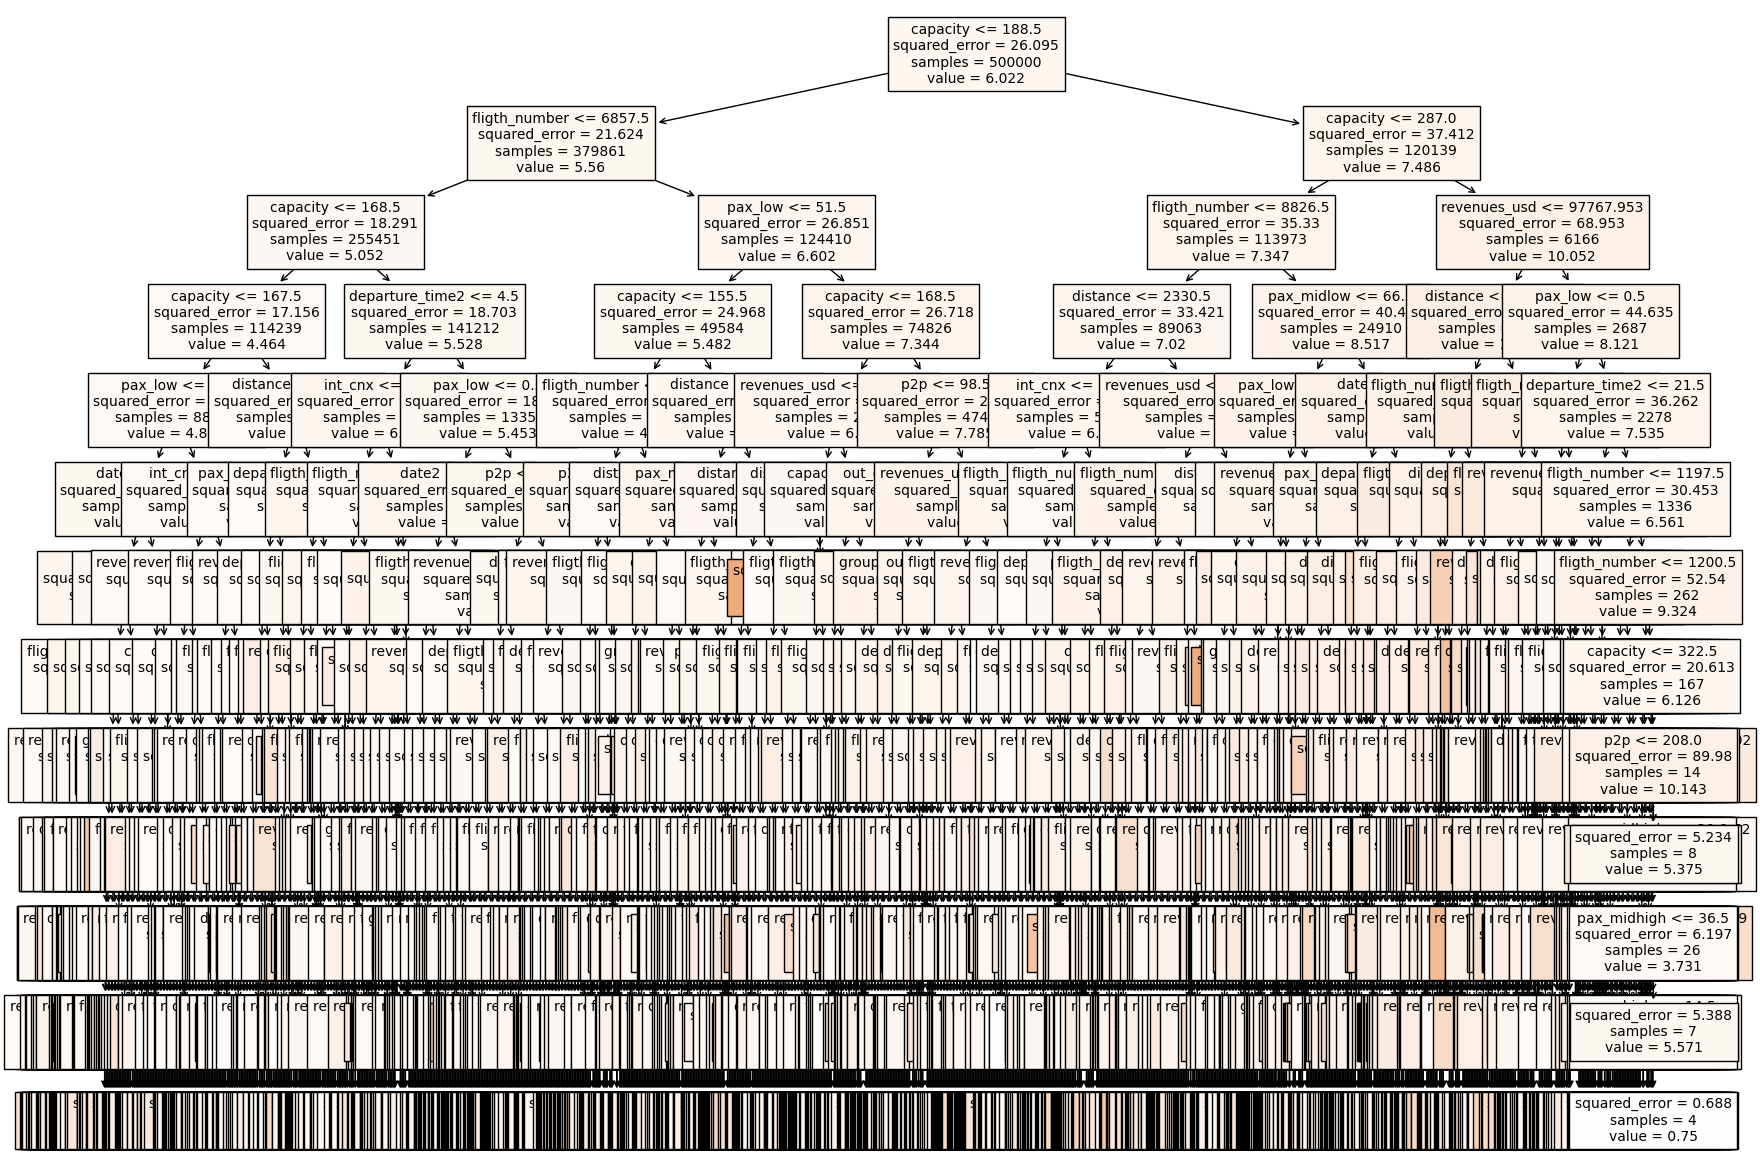

In [ ]:
#Graficando el arbol
mejora2.fit(X, y)
plt.figure(figsize=(20, 15))
plot_tree(mejora2, filled=True, feature_names=X.columns, fontsize=10)
plt.show()

Igual que el caso anterior, el gráfico se presenta de manera complementaria, pero no se puede visualizar de buena manera la división y la selección de variables que va realizando.

-------------------

Tercera opción: después de aplicar forward selection.

Este punto se dividirá en 2:

En 3.1 se realizará con un Mutual Information Regression
-  Donde se permite evaluar la influencia y la importancia de diferentes variables en un modelo de regresión.

En 3.2 con un Forward Stepwise selection.
- Donde se seleccionan características en análisis de datos y modelado comenzando con un modelo nulo y, de manera iterativa y progresiva, agrega las características que más influyen para la mejora del modelo.

3.1:

In [ ]:
#3.1
#Mutual information regression
df3=resample(df2,n_samples=500000,replace=False,random_state=1)
X = df3.drop('noshow', axis=1)
y = df3['noshow']
mi = mutual_info_regression(X, y)
mi_df = pd.DataFrame({'Feature': X.columns, 'Mutual_Information': mi})
mi_df = mi_df.sort_values(by='Mutual_Information', ascending=False)

In [ ]:
todas_las_variables = mi_df['Feature'].tolist()
variables_con_0_mi = mi_df[mi_df['Mutual_Information'] == 0]['Feature'].tolist()
variables_distintas_a0 = set(todas_las_variables).difference(set(variables_con_0_mi))
print("Largo variables totales:",len(todas_las_variables))
print("Largo variables igual a 0:",len(variables_con_0_mi))
print("Variables iguales a 0 que se eliminarán:")
print(variables_con_0_mi)

Largo variables totales: 175
Largo variables igual a 0: 78
Variables iguales a 0 que se eliminarán:
['CUN', 'PCL', 'LPB', 'JTC', 'USH', 'FOR', 'FCO', 'GPS', 'JJG', 'SJP', 'IQQ', 'SJO', 'CGR', 'LHR', 'TPP', 'TUC', 'CDG', 'TBP', 'VVI', 'PVH', 'ARI', 'VUP', 'IMP', 'CJA', 'MPN', 'SLA', 'FLN', 'IOS', 'BCN', 'RAO', 'JOI', 'JFK', 'PEI', 'CCS', 'CPO', 'GRU', 'ANF', 'BGA', 'RGL', 'BBA', 'BOS', 'PEM', 'CIX', 'ADZ', 'MCZ', 'SYD', 'SCL', 'AYP', 'LAS', 'pax_high', 'denied_boarding', 'SLZ', 'NQN', 'PDP', 'VIX', 'UNA', 'FRA', 'MCP', 'ASU', 'GDL', 'MAD', 'LSC', 'PPT', 'CCP', 'GYN', 'JUL', 'MAB', 'RBR', 'AKL', 'IGR', 'BSB', 'MCO', 'SJK', 'IQT', 'ZCO', 'ZOS', 'SMR', 'MEX']


Se eliminarán todas las variables que tienen Mutual Informationa 0, ya que no explican la variable dependiente. A raíz de esto, se aplicarán los modelos sin estas variables.

In [ ]:
#3.1
#k-NN: después de aplicar MIR
#Definir variables
#El análisis se hizo antes de esto y se eliminan en línea 9 y 10

#Generar grupos de train y test
#Se hace sampleo por tiempos de ejecución de los códigos
df3 = resample(df2, n_samples=500000, replace=False, random_state=1)
columns_to_drop = ['noshow'] + variables_con_0_mi
X = df3.drop(columns=columns_to_drop)
y = df3['noshow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

#k-fold cross validation y obtención del mejor modelo
params31={'n_neighbors':[50,60,70], #Opciones de veciones para k-NN
        'weights': ['uniform','distance'], #Opciones para el peso
        'metric':['euclidean','manhattan'] #Opciones para la métrica de distancia
       }
knn31=KNeighborsRegressor() #Se crea el objeto knn sin especificar hiperparámetros
model31 = GridSearchCV(knn31, params31, n_jobs=-1, cv=5, verbose=3, scoring=smape_metric)
#knn es el modelo base, params los hiperparámetros, n_jobs=-1 para que se usen los núcleos disponibles,
#cv=5 es la cantidad de pliegues para k-fold, verbose=3 para mostrar el ajuste por cada intento y scoring para usar SMAPE
model31.fit(X_train,y_train) #Búsqueda de hiperparámetros con el conjunto de entrenamiento
#results31=pd.DataFrame(model31.cv_results_).sort_values(by="rank_test_score") #Resultados
print(model31.best_params_) #Mejores hiperparámetros con SMAPE
model31.best_estimator_ #modelo entrenado con los mejores hiperparámetros

Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'metric': 'manhattan', 'n_neighbors': 50, 'weights': 'distance'}


KNeighborsRegressor(metric='manhattan', n_neighbors=50, weights='distance')

In [ ]:
#Evaluación del modelo
modelo31=model31.best_estimator_
modelo31_eval=model_eval(modelo31, X_test, y_test,n=3.1)

Modelo: 3.1
SMAPE: 30.838832288963825


In [ ]:
#3.1
#DecisionTreeRegressor: después de aplicar MIR
#Definir variables
#El análisis se hizo antes de esto y se eliminan en línea 9 y 10

#Generar grupos de train y test
#Se hace sampleo por tiempos de ejecución de los códigos
df3 = resample(df2, n_samples=500000, replace=False, random_state=1)
columns_to_drop = ['noshow'] + variables_con_0_mi
X = df3.drop(columns=columns_to_drop)
y = df3['noshow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

#k-fold cross validation y obtención del mejor modelo
hiper31 = {
    'max_depth': [None, 10, 12, 13], # máxima profundidad del arbol
    'min_samples_split': [5, 10, 12], # numero minimo de puntos para separar un nodo.
    'min_samples_leaf': [4, 5, 6], # numero minimo de puntos que debe tener una hoja.
    #'min_impurity_decrease': [0.0, 0.01, 0.1], # disminución mínima en la impureza para dividir un nodo
    #'max_leaf_nodes': [None, 5, 8, 10] # número máximo de nodos hojas en el árbol
    #'splitter' : ["best"]
}
m31 = DecisionTreeRegressor()
grid_search31a = GridSearchCV(m31, hiper31, cv=5, scoring=smape_metric) #se busca minimizar
grid_search31a.fit(X_train, y_train) #Búsqueda de hiperparámetros con el conjunto de entrenamiento
#resultsa31=pd.DataFrame(grid_search31a.cv_results_).sort_values(by="rank_test_score") #Resultados
print(grid_search31a.best_params_) #Mejores hiperparámetros con SMAPE
grid_search31a.best_estimator_

{'max_depth': 12, 'min_samples_leaf': 4, 'min_samples_split': 12}


DecisionTreeRegressor(max_depth=12, min_samples_leaf=4, min_samples_split=12)

In [ ]:
#Evaluación del modelo
mejora31 = grid_search31a.best_estimator_ #modelo entrenado con los mejores hiperparámetros
modeloa31_eval=model_eval(mejora31, X_test, y_test,n=7.1)

Modelo: 7.1
SMAPE: 31.25765913500407


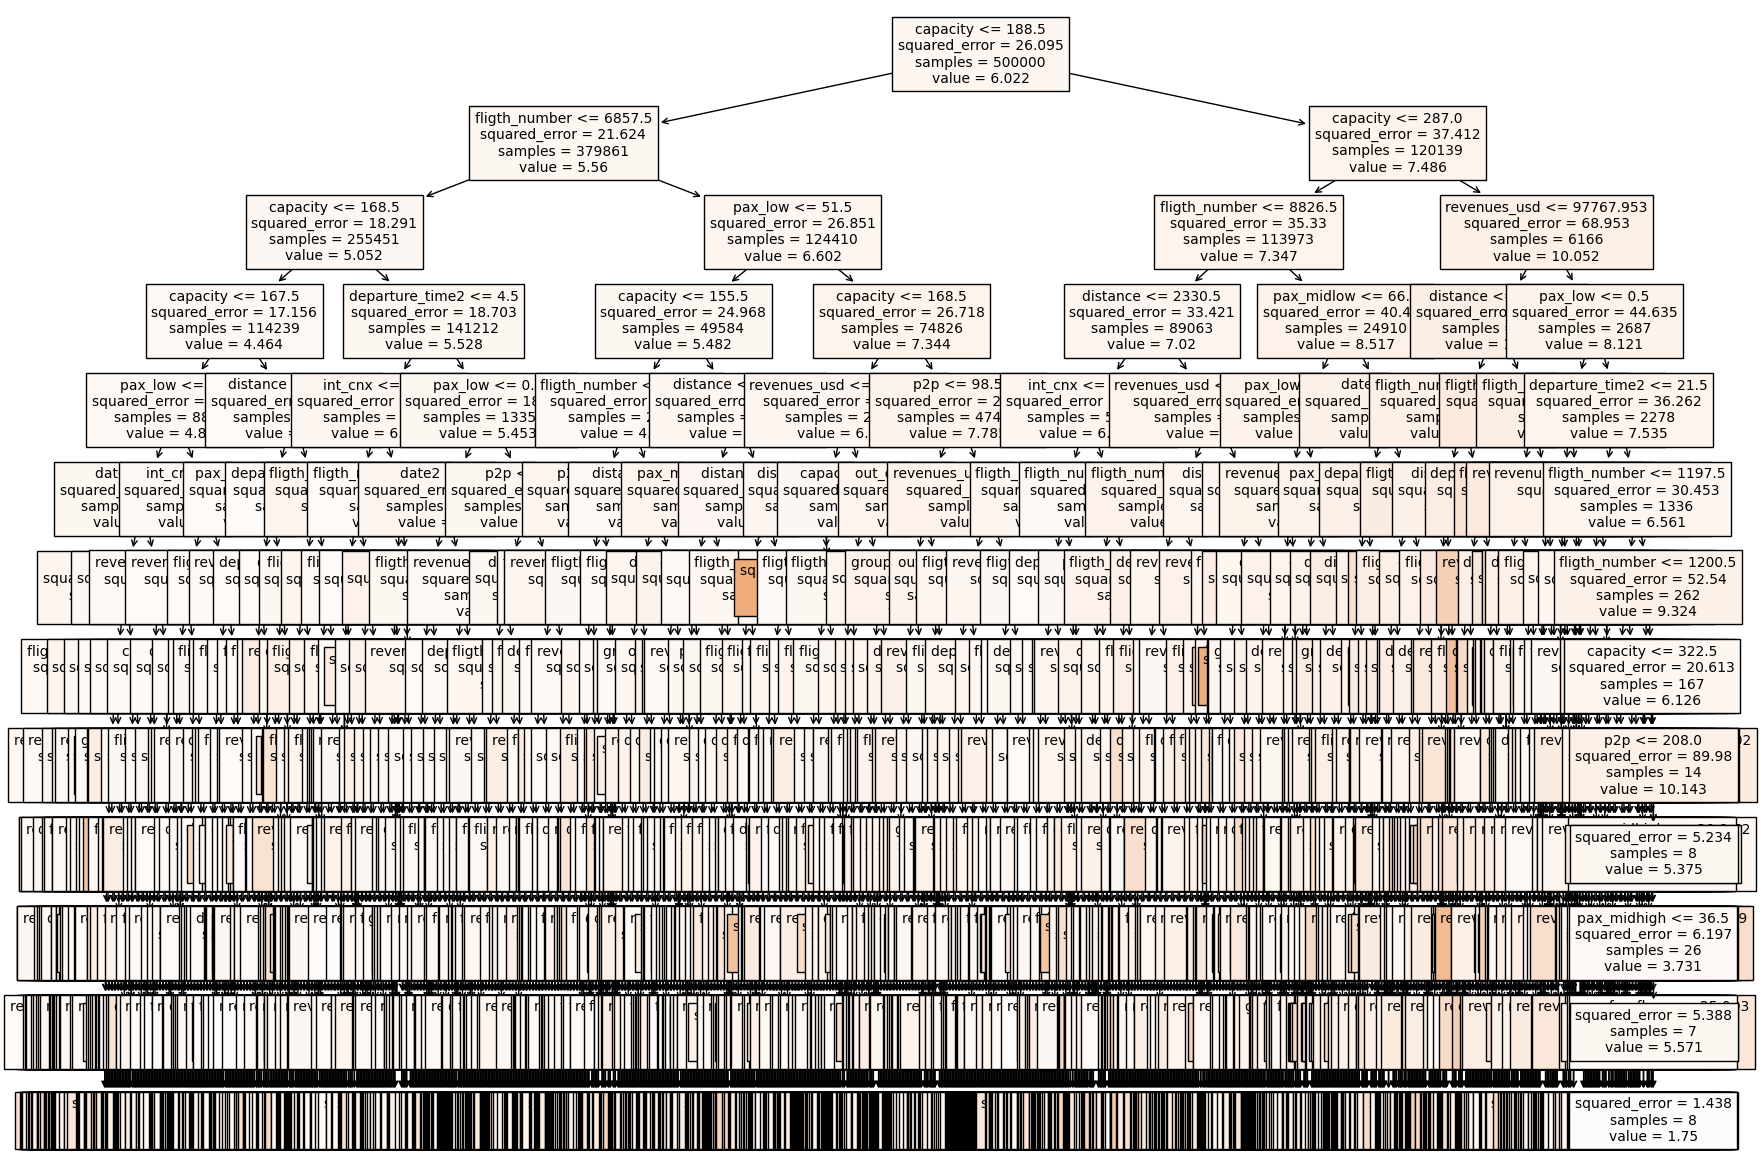

In [ ]:
#Graficando el arbol
mejora31.fit(X, y)
plt.figure(figsize=(20, 15))
plot_tree(mejora31, filled=True, feature_names=X.columns, fontsize=10)
plt.show()

3.2:

In [ ]:
#3.2
#Forward selection: Forward Stepwise selection
df3 = resample(df2, n_samples=500000, replace=False, random_state=1)
ar2 = dict() #Diccionario vacío para los R2
candidates = [] #Lista para las características
last_max = -1 #Para guardar el R2 máximo

y = 'noshow' #variable dependiente

while(True):
    for x in df3.drop([y] + candidates, axis=1).columns: #iterar por todas las columnas menos la dependiente
        if len(candidates) == 0:
            features = x
        else:
            features = x + ' + '
            features += ' + '.join(candidates)

        model = sm.ols(y + ' ~ ' + features, df3).fit() #Crear modelo de regresión
        ar2[x] = model.rsquared #Calculo R2

    max_ar2 =  max(ar2.values()) #R2 máximo hasta el paso en el que va
    max_ar2_key = max(ar2, key=ar2.get) #Características asociadas a ese R2 máximo

    if max_ar2 > last_max: #Verificar si el nuevo R2 es mayor que el anterior
        candidates.append(max_ar2_key) #Se agregan los candidatos
        last_max = max_ar2 #Se actualiza el R2

        print('step: ' + str(len(candidates)))
        print(candidates)
        print('Adjusted R2: ' + str(max_ar2))
        print('===============')
    else:
        print(model.summary())
        break

print('\n\n')
print('variables eliminadas: ')
print(set(df3.drop(y, axis=1).columns).difference(candidates))

step: 1
['capacity']
Adjusted R2: 0.03183839487513307
step: 2
['capacity', 'fligth_number']
Adjusted R2: 0.04286698669405231
step: 3
['capacity', 'fligth_number', 'p2p']
Adjusted R2: 0.04892642370334066
step: 4
['capacity', 'fligth_number', 'p2p', 'group_bookings']
Adjusted R2: 0.05375277112848942
step: 5
['capacity', 'fligth_number', 'p2p', 'group_bookings', 'pax_midlow']
Adjusted R2: 0.055651963606978216
step: 6
['capacity', 'fligth_number', 'p2p', 'group_bookings', 'pax_midlow', 'departure_time2']
Adjusted R2: 0.057333297360723234
step: 7
['capacity', 'fligth_number', 'p2p', 'group_bookings', 'pax_midlow', 'departure_time2', 'out_of_stock']
Adjusted R2: 0.05811355877651425
step: 8
['capacity', 'fligth_number', 'p2p', 'group_bookings', 'pax_midlow', 'departure_time2', 'out_of_stock', 'revenues_usd']
Adjusted R2: 0.05892091689964829
step: 9
['capacity', 'fligth_number', 'p2p', 'group_bookings', 'pax_midlow', 'departure_time2', 'out_of_stock', 'revenues_usd', 'distance']
Adjusted R2: 0

In [ ]:
#Revisar cuantas variables eliminadas están en las que se usaron en el one hot encoding
encoded_categories = set(encoded_cols.columns)
eliminated_variables = set(df3.drop(y, axis=1).columns).difference(candidates)
# Encontrar las variables eliminadas que no son one hot encoding
variables_not_in_eliminated = eliminated_variables.difference(encoded_categories)
print("Largo variables eliminadas:",len(eliminated_variables))
print("Largo variables one hot encoding:",len(encoded_categories))
print("Variables eliminadas que no son one hot encoding:")
print(variables_not_in_eliminated)
print("Se puede ver que forward selection concluye que hay que eliminar todas las variables aplicadas con one hot encoding.")

Largo variables eliminadas: 159
Largo variables one hot encoding: 157
Variables eliminadas que no son one hot encoding:
{'int_cnx', 'pax_low'}
Se puede ver que forward selection concluye que hay que eliminar todas las variables aplicadas con one hot encoding.


Se eliminarán las variables de one hot encoding y se corroborará que las variables a eliminar también son pax_low e int_cnx

In [ ]:
#Para comprobar eliminación de pax_low e int_cnx se vuelve a la data original
df2 = df.copy()
df2.drop(['Unnamed: 0','origin', 'destination','date', 'departure_time'], axis=1, inplace=True)
df3=resample(df2,n_samples=500000,replace=False,random_state=1)
df3.head(4)

,fligth_number,distance,noshow,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,out_of_stock,dom_cnx,int_cnx,p2p,capacity,revenues_usd,bookings,date2,departure_time2
686953,5237,215,8.0,0,3,0,0,85,7,0,0,0,13,82,144.0,5243.5,95,7,18
706057,4835,2067,0.0,0,56,0,1,43,8,0,0,8,2,98,168.0,6689.6,108,3,4
915720,1164,9399,5.0,0,200,0,4,165,21,13,0,0,199,191,323.0,86865.6,390,2,21
822152,6852,3934,5.0,0,131,0,2,122,5,0,0,0,131,129,168.0,30570.1,260,1,16


In [ ]:
#Se aplicará forward selection nuevamente para corrobar que las variables a eliminar son pax_low e int_cnx
ar2 = dict()
candidates = []
last_max = -1

y = 'noshow'

while(True):
    for x in df3.drop([y] + candidates, axis=1).columns:
        if len(candidates) == 0:
            features = x
        else:
            features = x + ' + '
            features += ' + '.join(candidates)

        model = sm.ols(y + ' ~ ' + features, df3).fit()
        ar2[x] = model.rsquared

    max_ar2 =  max(ar2.values())
    max_ar2_key = max(ar2, key=ar2.get)

    if max_ar2 > last_max:
        candidates.append(max_ar2_key)
        last_max = max_ar2

        print('step: ' + str(len(candidates)))
        print(candidates)
        print('Adjusted R2: ' + str(max_ar2))
        print('===============')
    else:
        print(model.summary())
        break

print('\n\n')
print('elminated variables: ')
print(set(df3.drop(y, axis=1).columns).difference(candidates))

step: 1
['capacity']
Adjusted R2: 0.03183839487513307
step: 2
['capacity', 'fligth_number']
Adjusted R2: 0.04286698669405231
step: 3
['capacity', 'fligth_number', 'p2p']
Adjusted R2: 0.04892642370334066
step: 4
['capacity', 'fligth_number', 'p2p', 'group_bookings']
Adjusted R2: 0.05375277112848942
step: 5
['capacity', 'fligth_number', 'p2p', 'group_bookings', 'pax_midlow']
Adjusted R2: 0.055651963606978216
step: 6
['capacity', 'fligth_number', 'p2p', 'group_bookings', 'pax_midlow', 'departure_time2']
Adjusted R2: 0.057333297360723234
step: 7
['capacity', 'fligth_number', 'p2p', 'group_bookings', 'pax_midlow', 'departure_time2', 'out_of_stock']
Adjusted R2: 0.05811355877651425
step: 8
['capacity', 'fligth_number', 'p2p', 'group_bookings', 'pax_midlow', 'departure_time2', 'out_of_stock', 'revenues_usd']
Adjusted R2: 0.05892091689964829
step: 9
['capacity', 'fligth_number', 'p2p', 'group_bookings', 'pax_midlow', 'departure_time2', 'out_of_stock', 'revenues_usd', 'distance']
Adjusted R2: 0

Se confirma que las variables a eliminar según forward selection son pax_low e int_cnx. Por lo que los modelos no usarán las variables de one hot encoding, ni int_cnx y pax_low.

In [ ]:
#Data sin las variables eliminadas
variables_not_in_eliminated=(df3.drop(y, axis=1).columns).difference(candidates).tolist()
columns_to_drop = ['Unnamed: 0','origin', 'destination','date', 'departure_time'] + variables_not_in_eliminated
df2 = df.copy()
df2.drop(columns=columns_to_drop, axis=1, inplace=True)

In [ ]:
#3.2
#k-NN después de aplicar forward selection
#Definir variables
#Se hizo antes de esto

#Generar grupos de train y test
#Se hace sampleo por tiempos de ejecución de los códigos
df3=resample(df2,n_samples=500000,replace=False,random_state=1)
X = df3.drop(columns=['noshow'])
y = df3['noshow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

#k-fold cross validation y obtención del mejor modelo
params32={'n_neighbors':[50,60,70], #Opciones de veciones para k-NN
        'weights': ['uniform','distance'], #Opciones para el peso
        'metric':['euclidean','manhattan'] #Opciones para la métrica de distancia
       }
knn32=KNeighborsRegressor() #Se crea el objeto knn sin especificar hiperparámetros
model32 = GridSearchCV(knn32, params32, n_jobs=-1, cv=5, verbose=3, scoring=smape_metric)
#knn es el modelo base, params los hiperparámetros, n_jobs=-1 para que se usen los núcleos disponibles,
#cv=5 es la cantidad de pliegues para k-fold, verbose=3 para mostrar el ajuste por cada intento y scoring para usar SMAPE
model32.fit(X_train,y_train) #Búsqueda de hiperparámetros con el conjunto de entrenamiento
#results32=pd.DataFrame(model32.cv_results_).sort_values(by="rank_test_score") #Resultados
print(model32.best_params_) #Mejores hiperparámetros con SMAPE
model32.best_estimator_ #modelo entrenado con los mejores hiperparámetros

Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'metric': 'manhattan', 'n_neighbors': 60, 'weights': 'distance'}


KNeighborsRegressor(metric='manhattan', n_neighbors=60, weights='distance')

In [ ]:
#Evaluación del modelo
modelo32=model32.best_estimator_
modelo32_eval=model_eval(modelo32, X_test, y_test,n=3.2)

Modelo: 3.2
SMAPE: 30.86185681267134


In [ ]:
#3.2
#DecisionTreeRegressor después de aplicar forward selection
#Definir variables
#Se hizo antes de esto

#Generar grupos de train y test
#Se hace sampleo por tiempos de ejecución de los códigos
df3=resample(df2,n_samples=500000,replace=False,random_state=1)
X = df3.drop(columns=['noshow'])
y = df3['noshow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)


#k-fold cross validation y obtención del mejor modelo
hiper32 = {
    'max_depth': [None, 10, 12, 13], # máxima profundidad del arbol
    'min_samples_split': [5, 10, 12], # numero minimo de puntos para separar un nodo.
    'min_samples_leaf': [4, 5, 6], # numero minimo de puntos que debe tener una hoja.
    #'min_impurity_decrease': [0.0, 0.01, 0.1], # disminución mínima en la impureza para dividir un nodo
    #'max_leaf_nodes': [None, 5, 8, 10] # número máximo de nodos hojas en el árbol
    #'splitter' : ["best"]
}
m32 = DecisionTreeRegressor()
grid_search32a = GridSearchCV(m32, hiper32, cv=5, scoring=smape_metric) #se busca minimizar
grid_search32a.fit(X_train, y_train) #Búsqueda de hiperparámetros con el conjunto de entrenamiento
#resultsa32=pd.DataFrame(grid_search32a.cv_results_).sort_values(by="rank_test_score") #Resultados
print(grid_search32a.best_params_) #Mejores hiperparámetros con SMAPE
grid_search32a.best_estimator_

{'max_depth': 12, 'min_samples_leaf': 5, 'min_samples_split': 12}


DecisionTreeRegressor(max_depth=12, min_samples_leaf=5, min_samples_split=12)

In [ ]:
#Evaluación del modelo
mejora32 = grid_search32a.best_estimator_ #modelo entrenado con los mejores hiperparámetros
modeloa32_eval=model_eval(mejora32, X_test, y_test,n=7.2)

Modelo: 7.2
SMAPE: 31.295468782658975


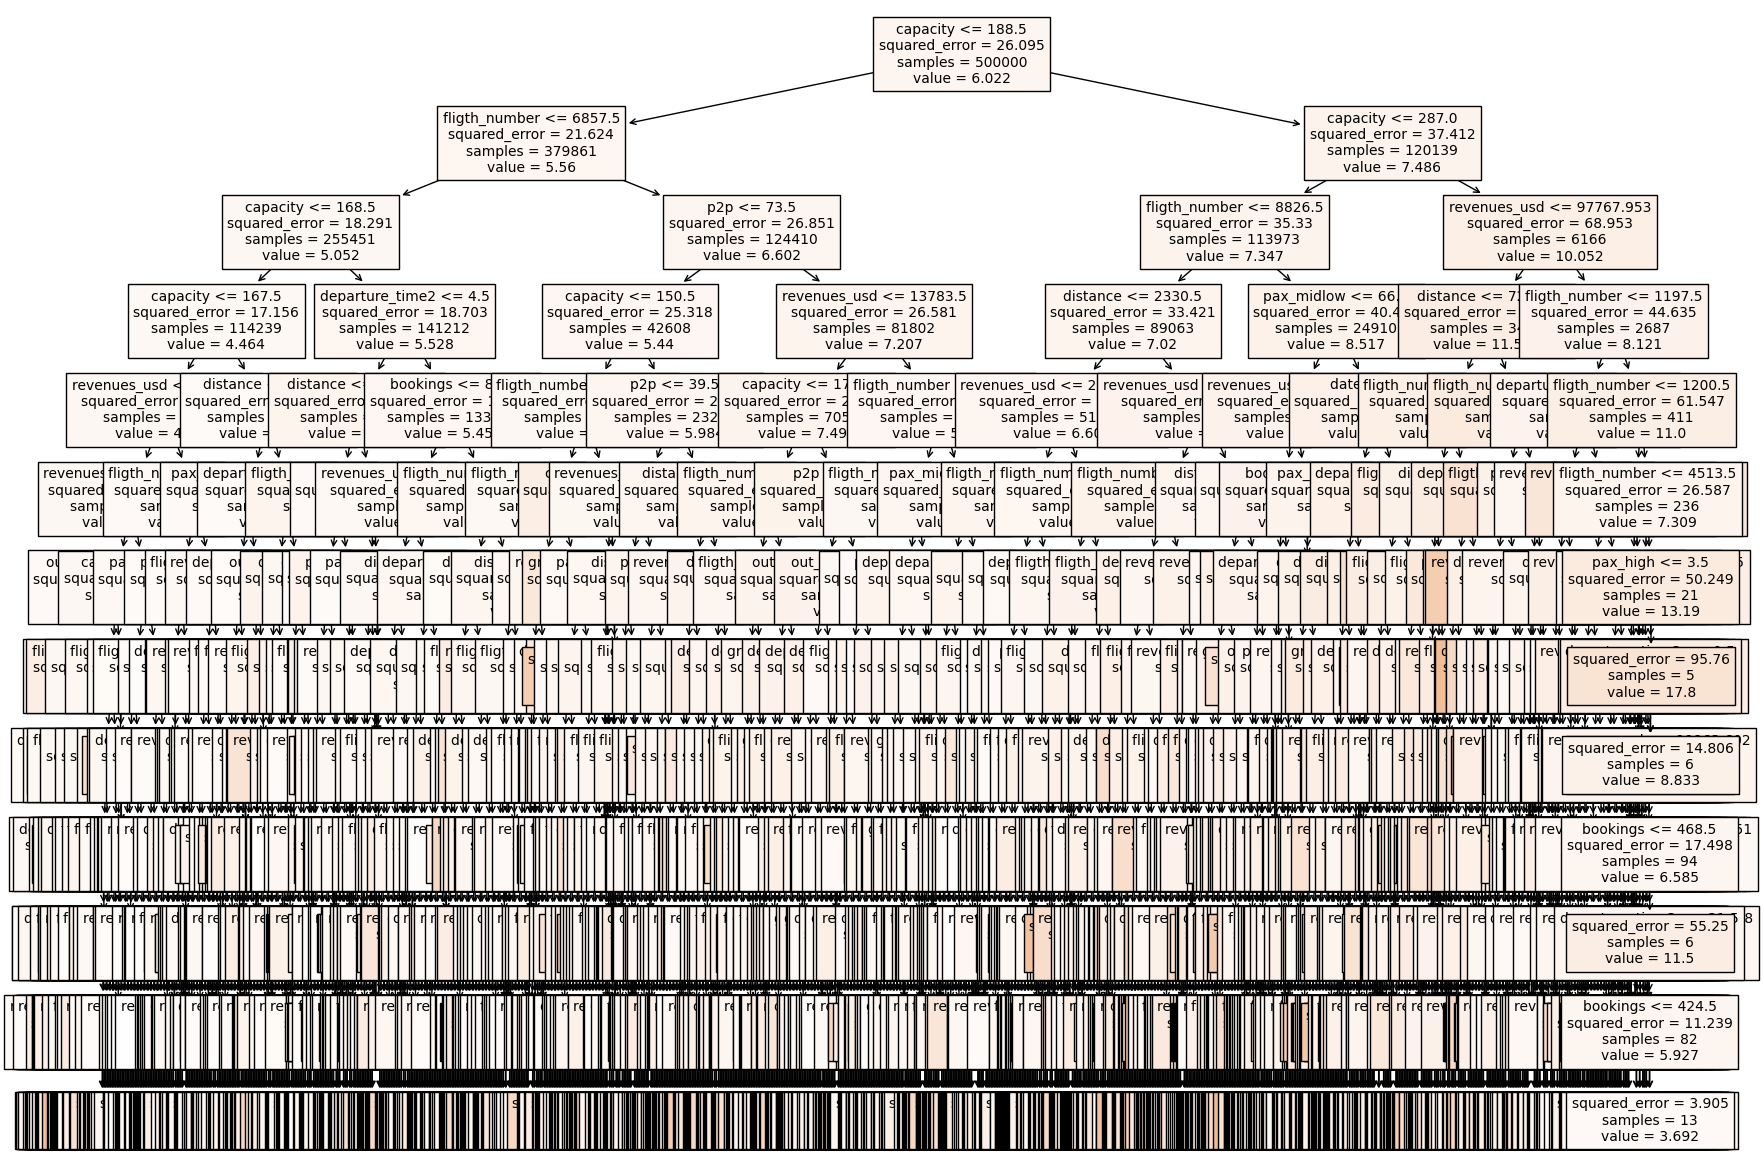

In [ ]:
#Graficando el arbol
mejora32.fit(X, y)
plt.figure(figsize=(20, 15))
plot_tree(mejora32, filled=True, feature_names=X.columns, fontsize=10)
plt.show()

En esta opción, que se separa en la aplicación de los modelos a partir de dos técnicas de forward selection, se puede ver que las dos opciones .1 (modelos 3.1 y 7.1) tienen mejores rendimientos SMAPE que las opciones .2 (modelos 3.2 y 7.2), es decir, la selección de variables con Regresión de Información Mutua tiene mejor rendimiento que Forward Stepwise Selection, tanto en k-NN como en árbol. La comparación final entre las opciones .1 (modelo 3.1 y 7.1) evidencia que nuevamente k-NN (modelo 3.1) se comporta mejor que el árbol (modelo 7.1), algo que ocurre también en las opciones .2.

El mejor SMAPE de esta opción, el k-NN .1 (modelo 3.1), tiene mejor SMAPE que el k-NN de la opción 1 (modelo 1), pero es un poco peor que el k-NN de la opción 2 (modelo 2).

Nuevamente se presentan los gráficos de árbol de forma complementaria.

----------------

Cuarta opción: Todas las variables originales, con date y departure_time transformado, menos las categóricas.

In [ ]:
#Cuarto k-NN: Todas las variables originales, con date y departure_time transformado, menos las categóricas.
#Definir variables
df2=df.copy()
df2.drop(['Unnamed: 0','origin', 'destination','date', 'departure_time'], axis=1, inplace=True)

#Generar grupos de train y test
#Se hace sampleo por tiempos de ejecución de los códigos
df3=resample(df2,n_samples=500000,replace=False,random_state=1)
X = df3.drop(columns=['noshow'])
y = df3['noshow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

#k-fold cross validation y obtención del mejor modelo
params4={'n_neighbors':[50,60,70], #Opciones de veciones para k-NN
        'weights': ['uniform','distance'], #Opciones para el peso
        'metric':['euclidean','manhattan'] #Opciones para la métrica de distancia
       }
knn4=KNeighborsRegressor() #Se crea el objeto knn sin especificar hiperparámetros
model4 = GridSearchCV(knn4, params4, n_jobs=-1, cv=5, verbose=3, scoring=smape_metric)
#knn es el modelo base, params los hiperparámetros, n_jobs=-1 para que se usen los núcleos disponibles,
#cv=5 es la cantidad de pliegues para k-fold, verbose=3 para mostrar el ajuste por cada intento y scoring para usar SMAPE
model4.fit(X_train,y_train) #Búsqueda de hiperparámetros con el conjunto de entrenamiento
#results4=pd.DataFrame(model4.cv_results_).sort_values(by="rank_test_score") #Resultados
print(model4.best_params_) #Mejores hiperparámetros con SMAPE
model4.best_estimator_ #modelo entrenado con los mejores hiperparámetros

Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'metric': 'manhattan', 'n_neighbors': 60, 'weights': 'distance'}


KNeighborsRegressor(metric='manhattan', n_neighbors=60, weights='distance')

In [ ]:
#Evaluación del modelo
modelo4=model4.best_estimator_
modelo4_eval=model_eval(modelo4, X_test, y_test,n=4)

Modelo: 4
SMAPE: 30.825633044811944


In [ ]:
#Cuarto DecisionTreeRegressor: Todas las variables originales, con date y departure_time transformado, menos las categóricas.
#Definir variables
df2=df.copy()
df2.drop(['Unnamed: 0','origin', 'destination','date', 'departure_time'], axis=1, inplace=True)

#Generar grupos de train y test
#Se hace sampleo por tiempos de ejecución de los códigos
df3=resample(df2,n_samples=500000,replace=False,random_state=1)
X = df3.drop(columns=['noshow'])
y = df3['noshow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

#k-fold cross validation y obtención del mejor modelo
hiper4 = {
    'max_depth': [None, 10, 12, 13], # máxima profundidad del arbol
    'min_samples_split': [5, 10, 12], # numero minimo de puntos para separar un nodo.
    'min_samples_leaf': [4, 5, 6], # numero minimo de puntos que debe tener una hoja.
    #'min_impurity_decrease': [0.0, 0.01, 0.1], # disminución mínima en la impureza para dividir un nodo
    #'max_leaf_nodes': [None, 5, 8, 10] # número máximo de nodos hojas en el árbol
    #'splitter' : ["best"]
}
m4 = DecisionTreeRegressor()
grid_search4a = GridSearchCV(m4, hiper4, cv=5, scoring=smape_metric) #se busca minimizar
grid_search4a.fit(X_train, y_train) #Búsqueda de hiperparámetros con el conjunto de entrenamiento
#resultsa4=pd.DataFrame(grid_search4a.cv_results_).sort_values(by="rank_test_score") #Resultados
print(grid_search4a.best_params_) #Mejores hiperparámetros con SMAPE
grid_search4a.best_estimator_

{'max_depth': 12, 'min_samples_leaf': 4, 'min_samples_split': 12}


DecisionTreeRegressor(max_depth=12, min_samples_leaf=4, min_samples_split=12)

In [ ]:
#Evaluación del modelo
mejora4 = grid_search4a.best_estimator_ #modelo entrenado con los mejores hiperparámetros
modeloa4_eval=model_eval(mejora4, X_test, y_test,n=8)

Modelo: 8
SMAPE: 31.26165696975276


En la última opción, en la que se utilizan todas las variables originales junto con las transformaciones de 'date' y 'departure_time', excluyendo las variables categóricas, el modelo k-NN continúa superando al modelo de árbol en términos de rendimiento, basado en SMAPE. Esto indica que, incluso cuando se incluyen todas las variables originales y las transformaciones numéricas, k-NN sigue siendo la que tiene mejor rendimiento en términos de precisión de predicción.

El modelo k-NN tiene exactamente el mismo SMAPE que el modelo 2 de k-NN, y estos tienen el mejor rendimiento de todos los modelos empleados.

No se pone el gráfico de árbol porque es igual al de la opción 2.

-------------------------

Pregunta 4

Comparación final entre el modelo seleccionado de kNN versus regression tree

Ahora, es necesario comparar todos los modelos implementados con el fin de determinar cuál de ellos tiene el mejor rendimiento en términos de la métrica de evaluación SMAPE. Este proceso comparativo permitirá identificar qué modelo es más efectivo al momento de predecir y proporciona una visión más clara de los desempeño en términos la metrica establecida. 

Para esto, se entregan los rendimientos en SMAPE, y una tabla de rendimiento en tiempo de ejecución.

Es importante recordar que los modelos del 1 al 4 son k-NN y los modelos del 5 al 8 son árboles.

In [ ]:
#Comparación
print("Modelo 1:",modelo1_eval)
print("Modelo 2:",modelo2_eval)
print("Modelo 3.1:",modelo31_eval)
print("Modelo 3.2:",modelo32_eval)
print("Modelo 4:",modelo4_eval)
print("Modelo 5:",modeloa1_eval)
print("Modelo 6:",modeloa2_eval)
print("Modelo 7.1:",modeloa31_eval)
print("Modelo 7.2:",modeloa32_eval)
print("Modelo 8:",modeloa4_eval)


Modelo 1: 31.158898656775634
Modelo 2: 30.825633044811944
Modelo 3.1: 30.838832288963825
Modelo 3.2: 30.86185681267134
Modelo 4: 30.825633044811944
Modelo 5: 31.419696585275027
Modelo 6: 31.260830119459875
Modelo 7.1: 31.25765913500407
Modelo 7.2: 31.295468782658975
Modelo 8: 31.26165696975276


In [ ]:
valores = [modelo1_eval, modelo2_eval, modelo31_eval, modelo32_eval, modelo4_eval, modeloa1_eval, modeloa2_eval, modeloa31_eval, modeloa32_eval, modeloa4_eval]
minimo = min(valores)
print("El mínimo es:", minimo)
indice_minimo = valores.index(minimo)
print("El modelo con el valor mínimo es el modelo", indice_minimo + 1)

El mínimo es: 30.825633044811944
El modelo con el valor mínimo es el modelo 2


Tiempos de ejecución:

| Modelo | Tiempo de Ejecución (minutos, segundos)|
|--------|---------------------|
| Modelo 1 | 54,7 |
| Modelo 2 | 272,20 |
| Modelo 3.1 | 220,3 |
| Modelo 3.2 | 54,2 |
| Modelo 4 | 58,38 |
| Modelo 5 | 6,20 |
| Modelo 6 | 10,18 |
| Modelo 7.1 | 8,6 |
| Modelo 7.2 | 6,4 |
| Modelo 8 | 7,13 |


Con respecto a los rendimientos en SMAPE, se puede ver que los rendimientos k-NN son mejores que sus símiles de árbol en cada una de las opciones que se trabajaron. Se puede ver que el modelo que tiene menor SMAPE es el segundo (30,82563), pero este valor es coincidente con el del modelo 4. Esto se podría deber a que el one hot encoding no representa ninguna mejora con respecto a su no utilización, y que estas variables no tienen mucha "importancia" en el segundo modelo, y que la importancia está radicada en el cambio de las variables "date" y "departure_time".

Es importante destacar que los SMAPE se podrían disminuir con una búsqueda de hiperparámetros más grande (aumentando la grilla GridSearchCV), por ejemplo, evaluando en los k-NN todas las opciones de vecinos entre 1 y 100, pero esto es muy costoso computacionalmente. Debido al costo computacional y los límites de tiempo de entrega de este trabajo, no se puede profundizar en esto, pero sería interesante evaluar estas opciones en un computador más potente.

Por otro lado, y como se puede observar en la tabla, los tiempos respectivos de cada modelo varían significativamente. Se puede ver a simple vista que los modelos k-NN son mucho más costosos que los árboles en términos temporales.

En primer lugar, el Modelo 2, con un tiempo de 272,20 minutos, es el que requiere más tiempo para completar su proceso. Por otro lado, los Modelos más rápidos son los 5 y 7.2, con tiempos de 6,20 y 6,4 minutos respectivamente. Se puede observar, como se mencionó anteriormente, que los modelos de árbol requieren menos tiempo de procesamiento en comparación con los modelos k-NN. Esto se puede deber a que los modelos de árbol pueden construir su estructura mediante reglas de partición, lo que suele ser más rápido y eficiente; en cambio, los modelos k-NN, implican cálculos de distancia y, por lo tanto, pueden ser más exigentes en términos computacionales.

Esta variabilidad en los tiempos explica que la eficiencia de cada modelo difiere de manera considerable, lo que puede llegar a influir en la elección del modelo dependiendo del tiempo que se tenga para el proyecto. En este sentido, es importante considerar los tiempos y la precisión de cada modelo para quedarse con el mejor.

A partir de todo esto, se decide que el mejor modelo es el 4, ya que tiene un costo computacional y temporal mucho menor que el del modelo 2, y tiene igual SMAPE. Por estas razones, se utilizará el modelo 4 para predecir la variable noshow en la data de testeo evalData.csv.

COMPETENCIA

In [ ]:
df_test=pd.read_csv("C:/Users/benja/OneDrive/Escritorio/UAI/2023/Métodos de Aprendizaje de Máquinas/Tarea 2/evalData.csv")
df_test.head(2)

,Unnamed: 0,date,fligth_number,origin,destination,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,...,pax_freqflyer,group_bookings,out_of_stock,dom_cnx,int_cnx,p2p,departure_time,capacity,revenues_usd,bookings
0,145420,2009-04-27,5960,ADZ,MDE,989,0,143,2,0,...,5,5,0,53,0,179,13:27:00,174.0,7471.1,232
1,117679,2009-04-03,6960,PIU,LIM,849,0,62,0,2,...,0,0,0,0,0,126,22:30:00,144.0,3608.0,126


In [ ]:
#Análisis de NA
print("\nRevisión de NA's:")
print(np.sum(df_test.isna()))


Revisión de NA's:
Unnamed: 0           0
date                 0
fligth_number        0
origin               0
destination          0
distance             0
denied_boarding      0
pax_midlow           0
pax_high             0
pax_midhigh          0
pax_low              0
pax_freqflyer        0
group_bookings       0
out_of_stock         0
dom_cnx              0
int_cnx              0
p2p                  0
departure_time     345
capacity             0
revenues_usd         0
bookings             0
dtype: int64


Se decide que los NA se reemplazarán con la mediana de los horarios.

Para esto, se pasarán los horarios a minutos desde las 00:00 y se calculará la mediana. Luego, se obtendrá esta mediana en formato de horario haciendo el proceso inverso (de minutos a horas). Finalmente, se reemplazarán los NA con esta mediana.

In [ ]:
# Tratamiento de los NA
df_test2=df_test.copy()
# Se reemplazarán las horas NA con la mediana de los datos
# Pasar a formato de tiempo
df_test2['departure_time'] = pd.to_datetime(df_test2['departure_time'])

#Calculo de la mediana en minutos
mediana_departure_time_minutes = df_test2['departure_time'].dt.hour * 60 + df_test2['departure_time'].dt.minute
mediana_departure_time_minutes = mediana_departure_time_minutes.median()

#Pasar la mediana de minutos de vuelta a formato de tiempo
mediana_departure_time = pd.to_datetime(f'{int(mediana_departure_time_minutes // 60):02}:{int(mediana_departure_time_minutes % 60):02}:00').time()

#Reemplazo de los NA en 'departure_time' usando la mediana
df_test2['departure_time'].fillna(mediana_departure_time, inplace=True)

#Formatear 'departure_time' como texto en formato de hora
df_test2['departure_time'] = df_test2['departure_time'].apply(lambda x: x.strftime('%H:%M:%S'))

df_test2.head(5)

,Unnamed: 0,date,fligth_number,origin,destination,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,...,pax_freqflyer,group_bookings,out_of_stock,dom_cnx,int_cnx,p2p,departure_time,capacity,revenues_usd,bookings
0,145420,2009-04-27,5960,ADZ,MDE,989,0,143,2,0,...,5,5,0,53,0,179,13:27:00,174.0,7471.1,232
1,117679,2009-04-03,6960,PIU,LIM,849,0,62,0,2,...,0,0,0,0,0,126,22:30:00,144.0,3608.0,126
2,781281,2010-10-06,6776,LIM,GRU,3464,0,136,6,0,...,29,0,0,0,138,146,09:05:00,220.0,25139.9,284
3,291825,2009-08-22,6209,POA,GIG,1125,0,32,0,0,...,18,0,0,1,0,75,18:40:00,174.0,10307.6,76
4,723737,2010-08-19,5506,CNF,SDU,375,0,35,0,0,...,11,0,0,5,0,71,14:50:00,144.0,4590.9,76


In [ ]:
#Se comprueba que se hayan cambiado los indices correctos
diferencias = df_test.compare(df_test2)
print(diferencias)

       departure_time          
                 self     other
37                NaN  13:31:00
144               NaN  13:31:00
2208              NaN  13:31:00
3302              NaN  13:31:00
5837              NaN  13:31:00
...               ...       ...
246500            NaN  13:31:00
247102            NaN  13:31:00
247285            NaN  13:31:00
247336            NaN  13:31:00
248092            NaN  13:31:00

[345 rows x 2 columns]


In [ ]:
#Obtener los índices de filas con valores NA en df_test
indices_na_df_test = df_test[df_test['departure_time'].isna()].index
#Obtener los índices de las filas diferentes obtenidas usando compare()
indices_diferentes = diferencias.index
#Verificar si los índices son iguales
son_iguales_indices = set(indices_na_df_test) == set(indices_diferentes)
if son_iguales_indices:
    print("Los índices NA en df_test son iguales a los índices de diferencias")
else:
    print("Los índices NA en df_test no son iguales a los índices de diferencias")

Los índices NA en df_test son iguales a los índices de diferencias


In [ ]:
print("NA de df_test:",np.sum(df_test["departure_time"].isna()))
print("NA de df_test2:",np.sum(df_test2["departure_time"].isna()))
#Ya no hay NA

NA de df_test: 345
NA de df_test2: 0


In [ ]:
#Aplicar los cambios asociados al modelo 4, que se realizó con:
#Todas las variables originales, con date y departure_time transformados, menos las categóricas.
#Tratamiento de variables
#Variable date
df_test2['date'] = pd.to_datetime(df_test2['date'])
df_test2['date2'] = df_test2['date'].dt.month
print(df_test2[['date','date2']].head(3))
#Variable departure_time
#Por un tema de simplicidad, se decide que se tomará en cuenta solo la hora salida
df_test2['departure_time'] = pd.to_datetime(df_test2['departure_time']).dt.time
df_test2['departure_time2'] = df_test2['departure_time'].apply(lambda x: x.hour)
print(df_test2[['departure_time', 'departure_time2']].head(3))

df_test2.head(5)

        date  date2
0 2009-04-27      4
1 2009-04-03      4
2 2010-10-06     10
  departure_time  departure_time2
0       13:27:00               13
1       22:30:00               22
2       09:05:00                9


,Unnamed: 0,date,fligth_number,origin,destination,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,...,out_of_stock,dom_cnx,int_cnx,p2p,departure_time,capacity,revenues_usd,bookings,date2,departure_time2
0,145420,2009-04-27,5960,ADZ,MDE,989,0,143,2,0,...,0,53,0,179,13:27:00,174.0,7471.1,232,4,13
1,117679,2009-04-03,6960,PIU,LIM,849,0,62,0,2,...,0,0,0,126,22:30:00,144.0,3608.0,126,4,22
2,781281,2010-10-06,6776,LIM,GRU,3464,0,136,6,0,...,0,0,138,146,09:05:00,220.0,25139.9,284,10,9
3,291825,2009-08-22,6209,POA,GIG,1125,0,32,0,0,...,0,1,0,75,18:40:00,174.0,10307.6,76,8,18
4,723737,2010-08-19,5506,CNF,SDU,375,0,35,0,0,...,0,5,0,71,14:50:00,144.0,4590.9,76,8,14


In [ ]:
#Confirmar que el número de columnas es el correcto
num_filas, num_columnas = df_test2.shape
print(f"El DataFrame tiene {num_columnas} columnas.")

El DataFrame tiene 23 columnas.


In [ ]:
#Eliminación de variables
print(df_test2.shape)
X_eval = df_test2.drop(columns=['Unnamed: 0','origin', 'destination','date', 'departure_time'])
print(X_eval.shape)
X_eval.head()

(248880, 23)
(248880, 18)


,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,out_of_stock,dom_cnx,int_cnx,p2p,capacity,revenues_usd,bookings,date2,departure_time2
0,5960,989,0,143,2,0,82,5,5,0,53,0,179,174.0,7471.1,232,4,13
1,6960,849,0,62,0,2,62,0,0,0,0,0,126,144.0,3608.0,126,4,22
2,6776,3464,0,136,6,0,113,29,0,0,0,138,146,220.0,25139.9,284,10,9
3,6209,1125,0,32,0,0,26,18,0,0,1,0,75,174.0,10307.6,76,8,18
4,5506,375,0,35,0,0,30,11,0,0,5,0,71,144.0,4590.9,76,8,14


In [ ]:
#Estandarización
columnas_numericas = X_eval.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
X_eval_std = X_eval.copy()  #Copia para estandarizar
X_eval_std[columnas_numericas] = scaler.fit_transform(X_eval[columnas_numericas])
X_eval_std

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,out_of_stock,dom_cnx,int_cnx,p2p,capacity,revenues_usd,bookings,date2,departure_time2
0,-0.072852,-0.279863,-0.087264,1.511146,-0.251749,-0.616729,0.646995,-0.851219,0.090859,-0.323944,0.833669,-0.607117,1.102097,-0.126050,-0.408838,1.054005,-0.749836,-0.005692
1,0.415150,-0.362820,-0.087264,-0.302800,-0.528249,-0.421695,0.126480,-1.212237,-0.312933,-0.323944,-0.801274,-0.607117,0.292906,-1.038328,-0.621743,-0.489064,-0.749836,1.576638
2,0.325358,1.186709,-0.087264,1.354386,0.301250,-0.616729,1.453793,0.881664,-0.312933,-0.323944,-0.801274,2.518429,0.598261,1.272775,0.564936,1.810982,0.953042,-0.708949
3,0.048661,-0.199275,-0.087264,-0.974633,-0.528249,-0.616729,-0.810446,0.087426,-0.312933,-0.323944,-0.770426,-0.607117,-0.485749,-0.126050,-0.252511,-1.216927,0.385416,0.873380
4,-0.294405,-0.643691,-0.087264,-0.907449,-0.528249,-0.616729,-0.706343,-0.417999,-0.312933,-0.323944,-0.647034,-0.607117,-0.546820,-1.038328,-0.567573,-1.216927,0.385416,0.170123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248875,-0.387613,-0.649024,-0.087264,-0.526744,-0.389999,-0.226661,-1.487116,-0.779016,-0.312933,-0.323944,-0.276858,-0.607117,-0.928513,-1.038328,-0.276716,-1.406171,0.953042,0.873380
248876,0.327310,4.775219,-0.087264,1.869457,-0.113500,-0.324178,2.052385,0.520646,-0.312933,-0.323944,-0.801274,2.473131,1.254774,1.151138,2.620222,2.407830,-0.466023,-2.291279
248877,0.402950,-0.268604,-0.087264,-1.601676,-0.389999,-0.616729,-1.226858,1.098274,-0.312933,-0.323944,-0.616186,-0.516522,-1.065923,-0.278097,-0.005711,-1.639087,1.520668,-0.533135
248878,-0.290501,0.731628,-0.087264,0.145088,-0.113500,-0.129144,0.152506,2.903361,-0.232175,-0.323944,1.018757,-0.357980,0.506655,1.272775,0.135531,0.733745,-1.601275,-2.291279


In [ ]:
#Mejor modelo: 4
print(model4.best_estimator_)
modelo4

KNeighborsRegressor(metric='manhattan', n_neighbors=60, weights='distance')


KNeighborsRegressor(metric='manhattan', n_neighbors=60, weights='distance')

In [ ]:
#Predicción
y_preds_eval = modelo4.predict(X_eval_std)
print(f'Cantidad de predicciones: {y_preds_eval.size}')
print(f'Cantidad sin predecir: {len(y_preds_eval)-y_preds_eval.size}')
print("Minimo:",y_preds_eval.min())
print("Máximo:",y_preds_eval.max())
y_preds_eval #Predicciones

C:\Users\benja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(


Cantidad de predicciones: 248880
Cantidad sin predecir: 0
Minimo: 0.8537236539690092
Máximo: 25.040569708091446


array([ 5.7568034 ,  5.64236765,  8.34810705, ...,  4.34944035,
       10.37289319,  5.09943317])

In [ ]:
#Pasar a CSV
y_preds_eval_df = pd.DataFrame(y_preds_eval)
y_preds_eval_df.to_csv('Olivares_Valdes.csv', index=False, float_format='%.2f')